In [1]:
get_ipython().run_cell_magic('capture', '', '!pip install db-dtypes\n!pip install keras\n!pip install tensorflow\n')

In [2]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [3]:
get_ipython().run_cell_magic('capture', '', 'import pandas as pd\nimport numpy as np\nimport os\nfrom google.cloud import bigquery\nfrom google.oauth2 import service_account\nfrom google.cloud.bigquery import magics\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.linear_model import LassoCV\nfrom sklearn.model_selection import RepeatedKFold\nfrom sklearn.linear_model import BayesianRidge\nfrom sklearn.linear_model import ElasticNetCV\nfrom keras.models import Sequential\nfrom keras.layers import Bidirectional, LSTM, Dropout, Dense\n')

ModuleNotFoundError: No module named 'keras'

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query_main = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [6]:
query_job = bigquery_client.query(query_main)
unemployment_data = query_job.to_dataframe()

In [7]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [8]:
query_job = bigquery_client.query(query)
wage_data = query_job.to_dataframe()

In [9]:
query_pred = """
SELECT * 
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [10]:
query_job = bigquery_client.query(query_pred)
prediction_list = query_job.to_dataframe()

In [11]:
print(unemployment_data.info())
print(wage_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16833 entries, 0 to 16832
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uu_id                   16833 non-null  object
 1   timeperiod              16833 non-null  Int64 
 2   week_number             16833 non-null  Int64 
 3   countyfips              16833 non-null  Int64 
 4   tract                   16833 non-null  Int64 
 5   tract_name              16833 non-null  object
 6   total_claims            16833 non-null  Int64 
 7   edu_8th_or_less         13748 non-null  Int64 
 8   edu_grades_9_11         5942 non-null   Int64 
 9   edu_hs_grad_equiv       6036 non-null   Int64 
 10  edu_post_hs             3246 non-null   Int64 
 11  edu_unknown             12031 non-null  Int64 
 12  top_category_employer1  16833 non-null  object
 13  top_category_employer2  16833 non-null  object
 14  top_category_employer3  16833 non-null  object
 15  ge

In [12]:
# check shape of both frames to see if they are joinable
print('Unemployment df size:', unemployment_data.shape)
print('Wage df size:', wage_data.shape)

Unemployment df size: (16833, 25)
Wage df size: (525, 5)


In [13]:
unemployment_data.isnull().sum() / len(unemployment_data) * 100

uu_id                      0.000000
timeperiod                 0.000000
week_number                0.000000
countyfips                 0.000000
tract                      0.000000
tract_name                 0.000000
total_claims               0.000000
edu_8th_or_less           18.327096
edu_grades_9_11           64.700291
edu_hs_grad_equiv         64.141864
edu_post_hs               80.716450
edu_unknown               28.527298
top_category_employer1     0.000000
top_category_employer2     0.000000
top_category_employer3     0.000000
gender_female             77.217371
gender_male               76.647062
gender_na                  5.732787
race_amerindian            9.196222
race_asian                11.251708
race_black                57.678370
race_noanswer             40.064160
race_hawaiiannative        2.417870
race_other                52.028753
race_white                62.026971
dtype: float64

In [14]:
wage_data.isnull().sum() / len(wage_data) * 100

uu_id           0.0
countyfips      0.0
tract           0.0
tract_name      0.0
average_wage    0.0
dtype: float64

In [15]:
# replace values with 0
clean_unemploymentDf = unemployment_data.copy()
clean_unemploymentDf.fillna(0, inplace=True)
clean_unemploymentDf

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,...,0,0,0,0,0,11,0,0,0,0
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,0,108,...,76,35,0,0,0,0,0,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,0,0,...,0,0,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,0,0,...,0,0,0,0,0,10,0,0,0,0
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,0,69,...,90,65,0,0,0,135,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,f35320206f3dd1ffc411e4ac127caf92,20220618,25,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",21,0,0,0,...,0,0,0,0,0,0,0,0,0,14
16829,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,0,13,...,0,0,0,0,0,0,0,0,0,0
16830,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,0,13,...,0,0,0,0,0,0,0,0,0,0
16831,bbcb018f0e5e49e13636f6e78ce9f60f,20220326,13,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",53,0,0,48,...,0,0,0,0,0,0,0,0,0,0


In [16]:
clean_unemploymentDf.isnull().sum() #check

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
dtype: int64

In [17]:
get_ipython().run_cell_magic('capture', '', "unemp_dupl = clean_unemploymentDf[clean_unemploymentDf.duplicated()]\nprint('Duplicate rows: ', unemp_dupl)\n# ignore duplicates - different time periods\n")

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15549/3330649336.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = clean_unemploymentDf.corr()


<AxesSubplot: >

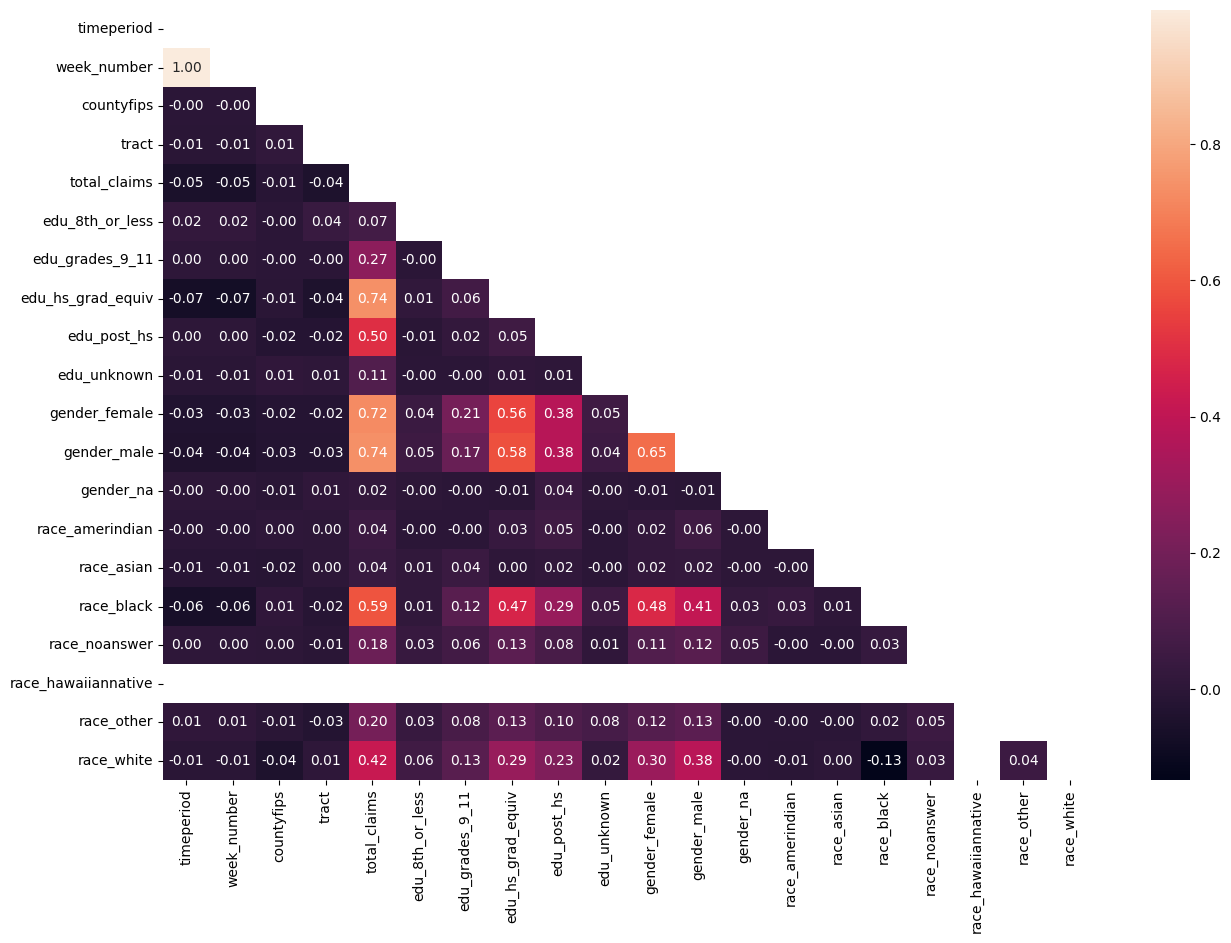

In [18]:
# check correlation
correlation = clean_unemploymentDf.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [19]:
# check wage information
wage_data[wage_data['average_wage'].isnull()] # there's 3 nulls here - might as well drop them and use this tract to attempt to join the datasets together; or impute with mean

,uu_id,countyfips,tract,tract_name,average_wage


In [20]:
#wage_data.dropna(axis=0, inplace=True)
wage_data['average_wage'].fillna(wage_data['average_wage'].mean(), inplace=True)
wage_data.isnull().sum()

uu_id           0
countyfips      0
tract           0
tract_name      0
average_wage    0
dtype: int64

In [21]:
wage_dupl = wage_data[wage_data.duplicated()]
print('Duplicate rows: ', wage_dupl)

Duplicate rows:  Empty DataFrame
Columns: [uu_id, countyfips, tract, tract_name, average_wage]
Index: []


In [22]:
# join df on tract
main_df = pd.merge(clean_unemploymentDf, wage_data, on=['tract', 'uu_id'], how='outer')

In [23]:
main_df

,uu_id,timeperiod,week_number,countyfips_x,tract,tract_name_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,countyfips_y,tract_name_y,average_wage
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,...,0,0,11,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
1,f013068de98db1470bd986137a0c6d23,20220212,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
2,f013068de98db1470bd986137a0c6d23,20220827,35,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
3,f013068de98db1470bd986137a0c6d23,20220312,11,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
4,f013068de98db1470bd986137a0c6d23,20220205,6,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,20220305,10,18113,971900,"Census Tract 9719, Noble County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16829,33f8f477e670b3cac704f4c0faa6e318,20220205,6,18113,971900,"Census Tract 9719, Noble County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16830,33f8f477e670b3cac704f4c0faa6e318,20220730,31,18113,971900,"Census Tract 9719, Noble County, Indiana",16,0,0,10,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16831,33f8f477e670b3cac704f4c0faa6e318,20220226,9,18113,971900,"Census Tract 9719, Noble County, Indiana",23,0,0,19,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706


In [24]:
# drop columns created by merge and rename existing columns to original
main_df.drop(['countyfips_y','tract_name_y'], axis=1, inplace=True)
main_df.rename({'countyfips_x':'countyfips', 'tract_name_x':'tract_name'}, axis=1, inplace=True)

In [25]:
main_df.isnull().sum() # check again

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
dtype: int64

In [26]:
main_df.dropna(axis=0, inplace=True) #most of the rows with NA values have nothing to add and cannot be imputed

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15549/4283123499.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = main_df.corr()


<AxesSubplot: >

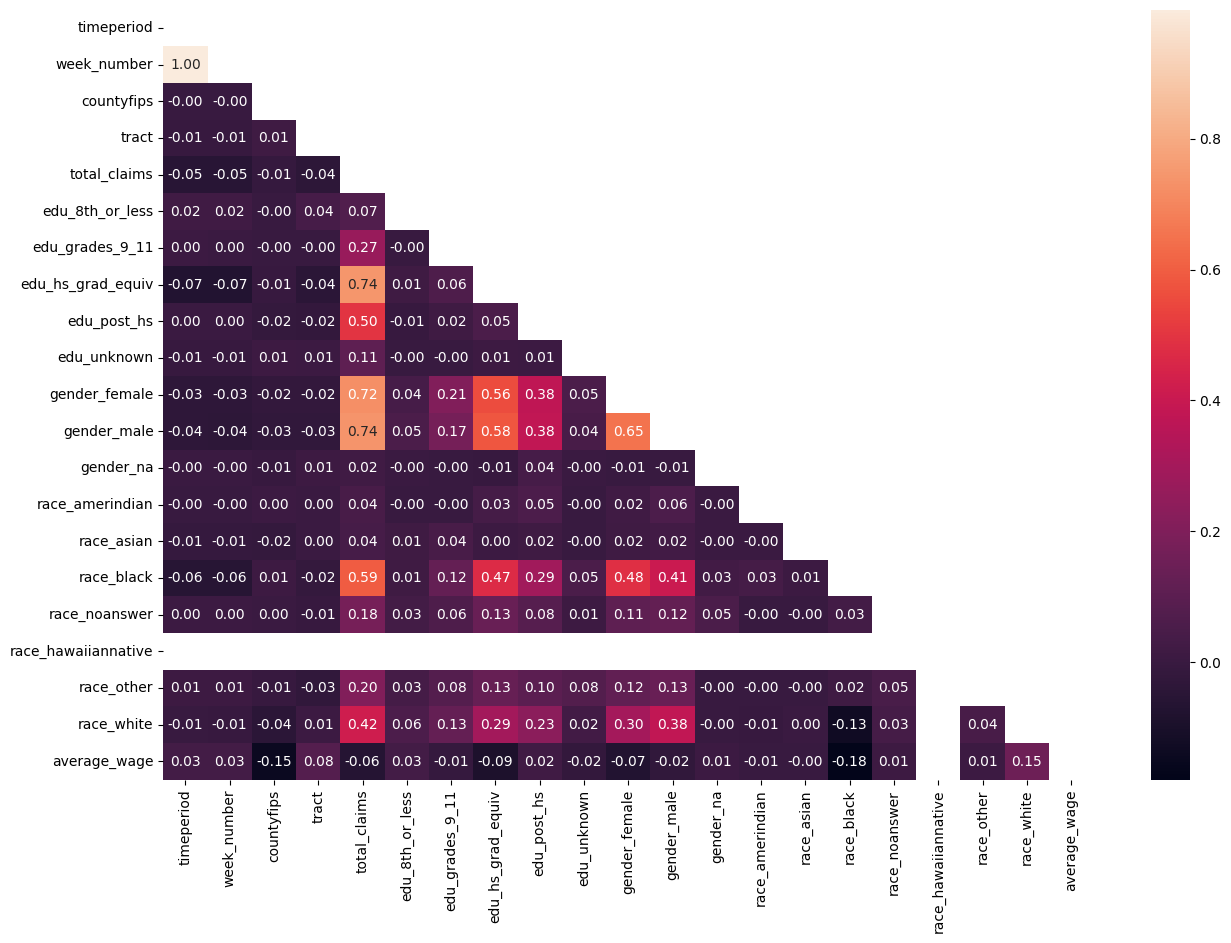

In [27]:
# check correlation again for new, merged frame
correlation = main_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [28]:
main_df.isnull().sum()

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
dtype: int64

In [29]:
def evaluate_regressor(prediction_dataframe):
    # Takes in a prediction dataframe of 2 columns, Actual values and Predicted values generated by a regressor
    # Outputs MSE, MAR, RMSE and MAPE metrics. Must have columns named Actual and Predicted.
    print('MSE:', mean_squared_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted']))
    print('MAE:', mean_absolute_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted']))
    print('RMSE:', np.sqrt(mean_squared_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted'])))
    print('MAPE:', np.mean(np.abs((prediction_dataframe['Actual'] - prediction_dataframe['Predicted']) / prediction_dataframe['Actual'])) * 100)

In [30]:
def get_predictions(regressor, model_type, name):
    # generates predictions for any model and writes out a dataframe in csv containing them
    # takes a regressor and learning method type as input: DL and ML
    # DL/ML variable basically changes the shape for an input from a 2D array to 3D arry, as required tensor shape
    result_list = []
    uu_id_transform = LE.fit_transform(prediction_list['uu_id'])
    if model_type == 'DL':
        predict_arr = np.array(SC_other.transform([[-0.04, -0.140, 0.328, -0.671, -0.420, -0.432, -0.0013, -0.0023, -0.347, -0.0004, 3.211, -0.532, -0.329]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, 43, axis=1)
            to_predict = np.reshape(to_predict, (to_predict.shape[0], to_predict.shape[1],1))
            r = regressor.predict(to_predict)
            result_list.append(r)
        result_list = np.array(result_list)
        result_list = np.reshape(result_list, (619,))
    elif model_type == 'ML':
        predict_arr = np.array(RB_other.transform([[-0.04, -0.140, 0.328, -0.671, -0.420, -0.432, -0.0013, -0.0023, -0.347, -0.0004, 3.211, -0.532, -0.329]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, 43, axis=1)
            r = regressor.predict(to_predict)
            result_list.append(r)
    result_df = pd.DataFrame(result_list, columns = ['Predictions'])
    prediction_sub = prediction_list.copy()
    prediction_sub['total_claims'] = result_df.values
    prediction_sub = prediction_sub[['uu_id','total_claims','week_number']]
    os.makedirs('lost+found/submission_files', exist_ok=True)
    prediction_sub.to_csv('lost+found/submission_files/'+name+'.csv', index=False)
    return prediction_sub

In [31]:
def get_pred_frame(test_frame, prediction_array):
    prediction_frame = pd.DataFrame({'Actual': test_frame, 'Predicted': prediction_array.flatten()})
    return prediction_frame

In [32]:
# updated_ingest = pd.concat([merged_ingest, combined_ingest])
ingest = pd.read_csv('lost+found/submission_files/updated_ingest.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'lost+found/submission_files/updated_ingest.csv'

In [33]:
ingest

NameError: name 'ingest' is not defined

In [34]:
ingest.shape

NameError: name 'ingest' is not defined

In [35]:
new_data = main_df.copy()
complete_ingest = pd.concat([ingest, new_data])
complete_ingest.shape

NameError: name 'ingest' is not defined

In [36]:
print(complete_ingest.shape)
print(ingest.shape)

NameError: name 'complete_ingest' is not defined

In [37]:
complete_ingest.isnull().sum()

NameError: name 'complete_ingest' is not defined

In [38]:
complete_ingest.dropna(axis=0, inplace=True)

NameError: name 'complete_ingest' is not defined

In [39]:
complete_ingest.shape

NameError: name 'complete_ingest' is not defined

In [40]:
# check if new data is duplicate
complete_ingest.equals(main_df)

NameError: name 'complete_ingest' is not defined

In [41]:
## write out combined data for use later
os.makedirs('lost+found/submission_files', exist_ok=True)
complete_ingest.to_csv('lost+found/submission_files/complete_ingest.csv', index=False)

NameError: name 'complete_ingest' is not defined

In [42]:
prediction_list.to_csv('prediction_list.csv')

In [43]:
get_ipython().run_cell_magic('capture', '', '!pip install db-dtypes\n!pip install keras\n!pip install tensorflow\n')

In [44]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [45]:
get_ipython().run_cell_magic('capture', '', 'import pandas as pd\nimport numpy as np\nimport os\nfrom google.cloud import bigquery\nfrom google.oauth2 import service_account\nfrom google.cloud.bigquery import magics\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.linear_model import LassoCV\nfrom sklearn.model_selection import RepeatedKFold\nfrom sklearn.linear_model import BayesianRidge\nfrom sklearn.linear_model import ElasticNetCV\nfrom keras.models import Sequential\nfrom keras.layers import Bidirectional, LSTM, Dropout, Dense\n')

ModuleNotFoundError: No module named 'keras'

In [46]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [47]:
query_main = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [48]:
query_job = bigquery_client.query(query_main)
unemployment_data = query_job.to_dataframe()

In [49]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [50]:
query_job = bigquery_client.query(query)
wage_data = query_job.to_dataframe()

In [51]:
query_pred = """
SELECT * 
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [52]:
query_job = bigquery_client.query(query_pred)
prediction_list = query_job.to_dataframe()

In [53]:
# replace values with 0
clean_unemploymentDf = unemployment_data.copy()
clean_unemploymentDf.fillna(0, inplace=True)
clean_unemploymentDf

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,...,0,0,0,0,0,11,0,0,0,0
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,0,108,...,76,35,0,0,0,0,0,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,0,0,...,0,0,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,0,0,...,0,0,0,0,0,10,0,0,0,0
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,0,69,...,90,65,0,0,0,135,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,f35320206f3dd1ffc411e4ac127caf92,20220618,25,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",21,0,0,0,...,0,0,0,0,0,0,0,0,0,14
16829,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,0,13,...,0,0,0,0,0,0,0,0,0,0
16830,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,0,13,...,0,0,0,0,0,0,0,0,0,0
16831,bbcb018f0e5e49e13636f6e78ce9f60f,20220326,13,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",53,0,0,48,...,0,0,0,0,0,0,0,0,0,0


In [54]:
clean_unemploymentDf.isnull().sum() #check

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
dtype: int64

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15549/3330649336.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = clean_unemploymentDf.corr()


<AxesSubplot: >

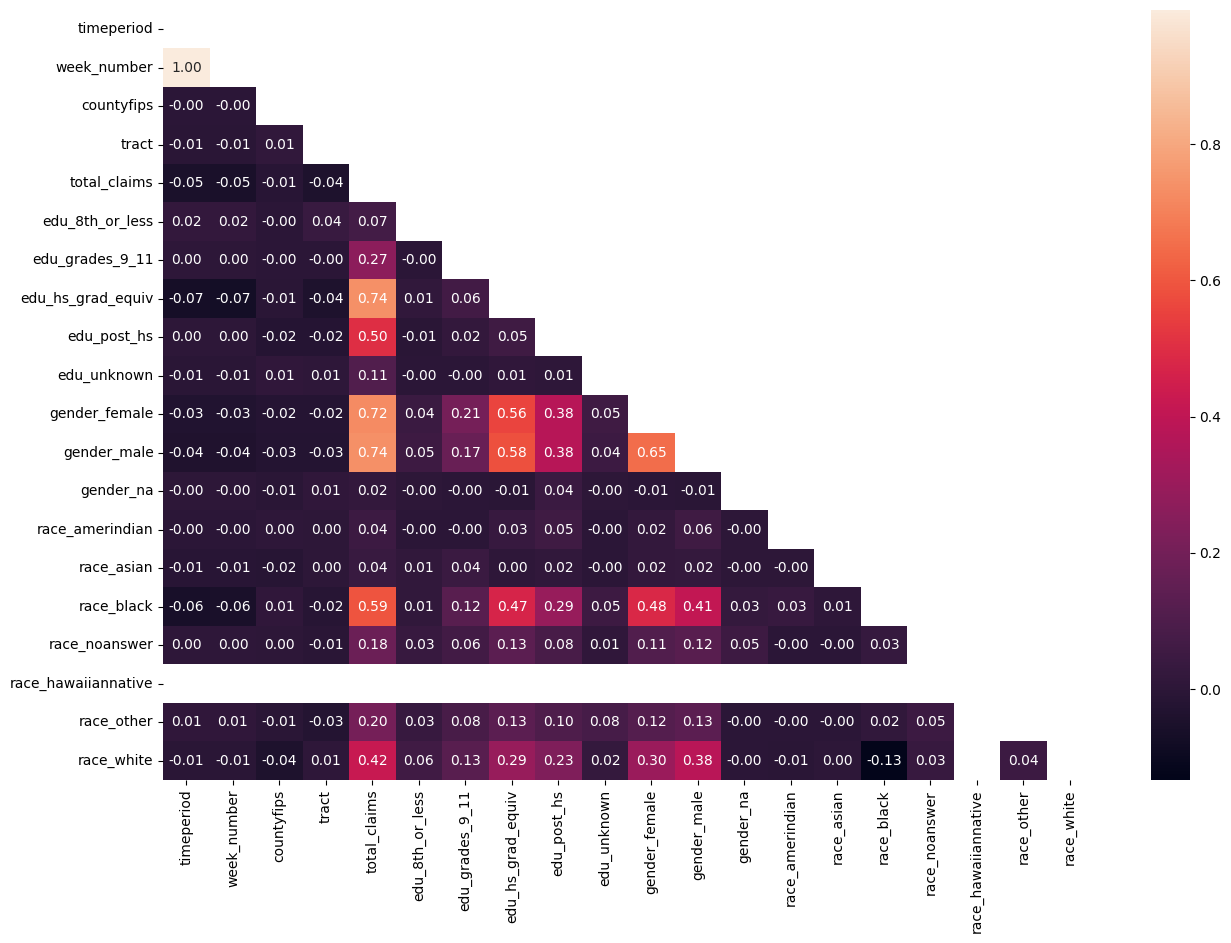

In [55]:
# check correlation
correlation = clean_unemploymentDf.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [56]:
# check wage information
wage_data[wage_data['average_wage'].isnull()] # there's 3 nulls here - might as well drop them and use this tract to attempt to join the datasets together; or impute with mean

,uu_id,countyfips,tract,tract_name,average_wage


In [57]:
#wage_data.dropna(axis=0, inplace=True)
wage_data['average_wage'].fillna(wage_data['average_wage'].mean(), inplace=True)
wage_data.isnull().sum()

uu_id           0
countyfips      0
tract           0
tract_name      0
average_wage    0
dtype: int64

In [58]:
wage_dupl = wage_data[wage_data.duplicated()]
print('Duplicate rows: ', wage_dupl)

Duplicate rows:  Empty DataFrame
Columns: [uu_id, countyfips, tract, tract_name, average_wage]
Index: []


In [59]:
# join df on tract
main_df = pd.merge(clean_unemploymentDf, wage_data, on=['tract', 'uu_id'], how='outer')

In [60]:
main_df

,uu_id,timeperiod,week_number,countyfips_x,tract,tract_name_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,countyfips_y,tract_name_y,average_wage
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,...,0,0,11,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
1,f013068de98db1470bd986137a0c6d23,20220212,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
2,f013068de98db1470bd986137a0c6d23,20220827,35,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
3,f013068de98db1470bd986137a0c6d23,20220312,11,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
4,f013068de98db1470bd986137a0c6d23,20220205,6,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,20220305,10,18113,971900,"Census Tract 9719, Noble County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16829,33f8f477e670b3cac704f4c0faa6e318,20220205,6,18113,971900,"Census Tract 9719, Noble County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16830,33f8f477e670b3cac704f4c0faa6e318,20220730,31,18113,971900,"Census Tract 9719, Noble County, Indiana",16,0,0,10,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16831,33f8f477e670b3cac704f4c0faa6e318,20220226,9,18113,971900,"Census Tract 9719, Noble County, Indiana",23,0,0,19,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706


In [61]:
# drop columns created by merge and rename existing columns to original
main_df.drop(['countyfips_y','tract_name_y'], axis=1, inplace=True)
main_df.rename({'countyfips_x':'countyfips', 'tract_name_x':'tract_name'}, axis=1, inplace=True)

In [62]:
main_df.isnull().sum() # check again

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
dtype: int64

In [63]:
main_df.dropna(axis=0, inplace=True) #most of the rows with NA values have nothing to add and cannot be imputed

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15549/4283123499.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = main_df.corr()


<AxesSubplot: >

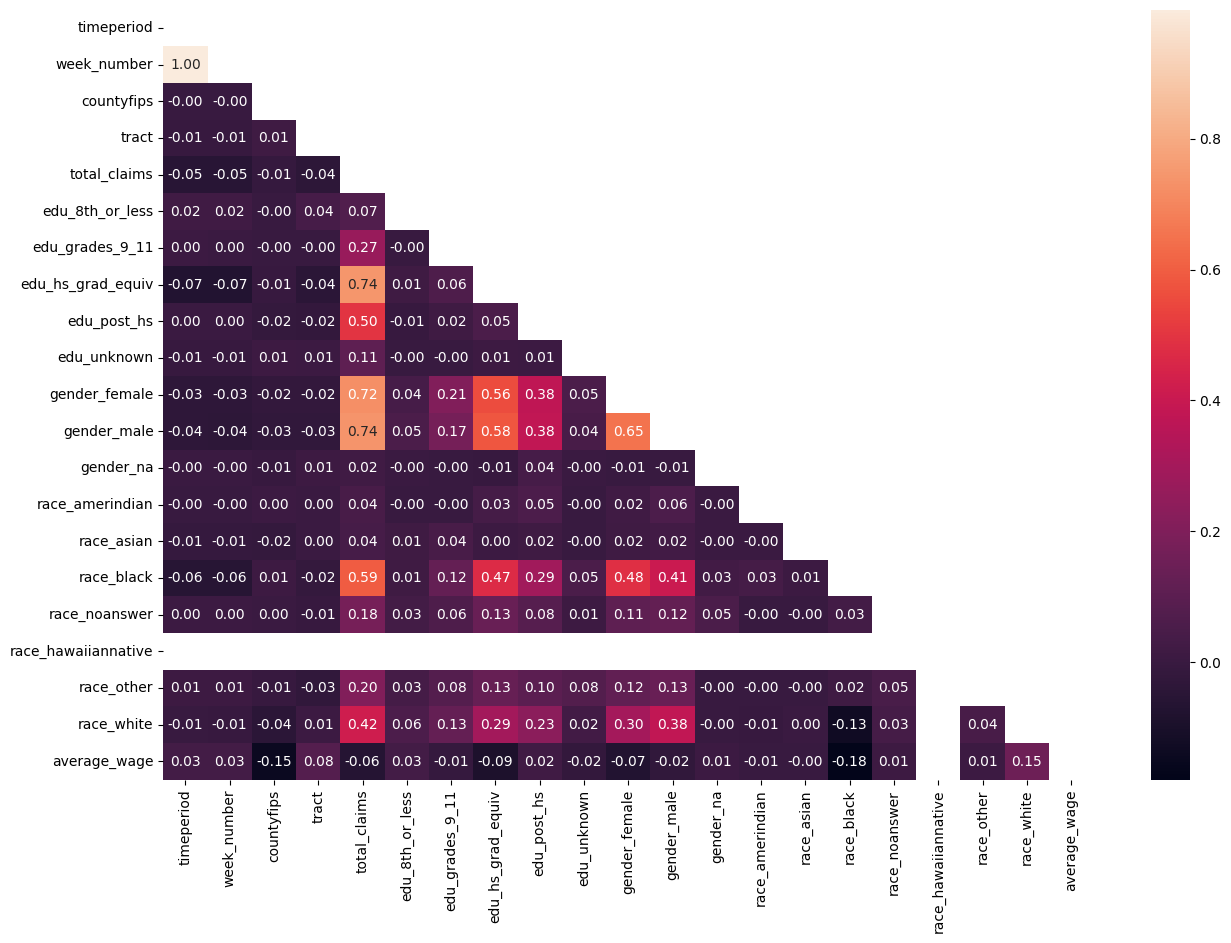

In [64]:
# check correlation again for new, merged frame
correlation = main_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [65]:
main_df.isnull().sum()

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
dtype: int64

In [66]:
get_ipython().run_cell_magic('capture', '', 'import pandas as pd\nimport numpy as np\nimport os\nfrom google.cloud import bigquery\nfrom google.oauth2 import service_account\nfrom google.cloud.bigquery import magics\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.linear_model import LassoCV\nfrom sklearn.model_selection import RepeatedKFold\nfrom sklearn.linear_model import BayesianRidge\nfrom sklearn.linear_model import ElasticNetCV\nfrom keras.models import Sequential\nfrom keras.layers import Bidirectional, LSTM, Dropout, Dense\nfrom keras.models import load_model\n')

ModuleNotFoundError: No module named 'keras'

In [67]:
# load model
StackLSTM_Regressor = load_model('BiDLSTM_v1-04.h5')

NameError: name 'load_model' is not defined

In [68]:
# summary for viewers
StackLSTM_Regressor.summary()

NameError: name 'StackLSTM_Regressor' is not defined

In [69]:
# quick preprocess to keep uu_id and scale values
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
LE = LabelEncoder()
RB_other = RobustScaler()
SC_other = StandardScaler()
# RB_claims = RobustScaler()

In [70]:
# this needs different feature engineering, so I'm starting from scratch
DL_data = updated_ingest.copy()

NameError: name 'updated_ingest' is not defined

In [71]:
# this needs different feature engineering, so I'm starting from scratch
DL_data = complete_ingest.copy()

NameError: name 'complete_ingest' is not defined

In [72]:
drop_these = ['timeperiod','tract','top_category_employer1','top_category_employer2','top_category_employer3','tract_name','countyfips', 'edu_unknown', 'gender_na', 'race_noanswer']
DL_data['uu_id'] = LE.fit_transform(DL_data['uu_id'])
scale_these = ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female', 'gender_male', 
            'race_amerindian', 'race_asian', 'race_black', 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
DL_data.drop(drop_these, axis = 1, inplace=True)
DL_data[scale_these] = SC_other.fit_transform(DL_data[scale_these])

NameError: name 'DL_data' is not defined

In [73]:
DL_data.columns

NameError: name 'DL_data' is not defined

In [74]:
# split set
DL_Y = DL_data['total_claims']
DL_X = DL_data[['uu_id', 'week_number', 'edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female', 'gender_male',
               'race_amerindian', 'race_asian', 'race_black', 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
DL_XTrain, DL_XTest, DL_YTrain, DL_YTest = train_test_split(DL_X, DL_Y, test_size=0.20, random_state=69)

NameError: name 'DL_data' is not defined

In [75]:
# change to np vectors
DL_XTrain = DL_XTrain.to_numpy()
DL_XTest = DL_XTest.to_numpy()

NameError: name 'DL_XTrain' is not defined

In [76]:
# reshape because F*** tensors
DL_XTrain = np.reshape(DL_XTrain, (DL_XTrain.shape[0], DL_XTrain.shape[1], 1))

NameError: name 'DL_XTrain' is not defined

In [77]:
# convert X and Y train to float because input dtype accepts floats only
DL_YTrain = DL_YTrain.astype(float)
DL_XTrain = DL_XTrain.astype(float)

NameError: name 'DL_YTrain' is not defined

In [78]:
# float cast
DL_XTest = DL_XTest.astype(float)
# make predictions
DL_XTest = np.reshape(DL_XTest, (DL_XTest.shape[0], DL_XTest.shape[1],1))
predictions = StackLSTM_Regressor.predict(DL_XTest)

NameError: name 'DL_XTest' is not defined

In [79]:
get_pred_frame(DL_YTest, predictions)

NameError: name 'DL_YTest' is not defined

In [80]:
evaluate_regressor(get_pred_frame(DL_YTest, predictions))

NameError: name 'DL_YTest' is not defined

In [81]:
plt.figure(figsize=(15,10))
plt.plot(DL_YTest.values, color = 'red', label = 'Actual values')
plt.plot(predictions, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()

NameError: name 'DL_YTest' is not defined

<Figure size 1500x1000 with 0 Axes>

In [82]:
get_predictions(StackLSTM_Regressor, 'DL', 'submission_prediction_output')

NameError: name 'StackLSTM_Regressor' is not defined

In [83]:
def get_predictions(regressor, model_type, name):
    # generates predictions for any model and writes out a dataframe in csv containing them
    # takes a regressor and learning method type as input: DL and ML
    # DL/ML variable basically changes the shape for an input from a 2D array to 3D arry, as required tensor shape
    result_list = []
    uu_id_transform = LE.fit_transform(prediction_list['uu_id'])
    if model_type == 'DL':
        predict_arr = np.array(SC_other.transform([[-0.04, -0.140, 0.328, -0.671, -0.420, -0.432, -0.0013, -0.0023, -0.347, -0.0004, 3.211, -0.532, -0.329]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, 43, axis=1)
            to_predict = np.reshape(to_predict, (to_predict.shape[0], to_predict.shape[1],1))
            r = regressor.predict(to_predict)
            result_list.append(r)
        result_list = np.array(result_list)
        result_list = np.reshape(result_list, (525,))
    elif model_type == 'ML':
        predict_arr = np.array(RB_other.transform([[-0.04, -0.140, 0.328, -0.671, -0.420, -0.432, -0.0013, -0.0023, -0.347, -0.0004, 3.211, -0.532, -0.329]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, 43, axis=1)
            r = regressor.predict(to_predict)
            result_list.append(r)
    result_df = pd.DataFrame(result_list, columns = ['Predictions'])
    prediction_sub = prediction_list.copy()
    prediction_sub['total_claims'] = result_df.values
    prediction_sub = prediction_sub[['uu_id','total_claims','week_number']]
    os.makedirs('lost+found/submission_files', exist_ok=True)
    prediction_sub.to_csv('lost+found/submission_files/'+name+'.csv', index=False)
    return prediction_sub

In [84]:
get_predictions(StackLSTM_Regressor, 'DL', 'submission_prediction_output')

NameError: name 'StackLSTM_Regressor' is not defined

In [85]:
def get_predictions(regressor, model_type, name, week):
    # generates predictions for any model and writes out a dataframe in csv containing them
    # takes a regressor and learning method type as input: DL and ML
    # DL/ML variable basically changes the shape for an input from a 2D array to 3D arry, as required tensor shape
    result_list = []
    uu_id_transform = LE.fit_transform(prediction_list['uu_id'])
    if model_type == 'DL':
        predict_arr = np.array(SC_other.transform([[-0.04, -0.140, 0.328, -0.671, -0.420, -0.432, -0.0013, -0.0023, -0.347, -0.0004, 3.211, -0.532, -0.329]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, week, axis=1)
            to_predict = np.reshape(to_predict, (to_predict.shape[0], to_predict.shape[1],1))
            r = regressor.predict(to_predict)
            result_list.append(r)
        result_list = np.array(result_list)
        result_list = np.reshape(result_list, (525,))
    elif model_type == 'ML':
        predict_arr = np.array(RB_other.transform([[-0.04, -0.140, 0.328, -0.671, -0.420, -0.432, -0.0013, -0.0023, -0.347, -0.0004, 3.211, -0.532, -0.329]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, week, axis=1)
            r = regressor.predict(to_predict)
            result_list.append(r)
    result_df = pd.DataFrame(result_list, columns = ['Predictions'])
    prediction_sub = prediction_list.copy()
    prediction_sub['total_claims'] = result_df.values
    prediction_sub = prediction_sub[['uu_id','total_claims','week_number']]
    os.makedirs('lost+found/submission_files', exist_ok=True)
    prediction_sub.to_csv('lost+found/submission_files/'+name+'.csv', index=False)
    return prediction_sub

In [86]:
get_predictions(StackLSTM_Regressor, 'DL', 'submission_prediction_output', 43)

NameError: name 'StackLSTM_Regressor' is not defined

In [87]:
prediction_list

,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44
3,a90462cd11ae4e43144239bf7c4828a4,44
4,8b20a6749088c7ff1237983076ebfeaa,44
...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44
521,1deebda501712e7595b531b8337bc31a,44
522,5a9758f65f001b6432ff31ff64a459d7,44
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44


In [88]:
get_predictions(StackLSTM_Regressor, 'DL', 'submission_prediction_output', 44)

NameError: name 'StackLSTM_Regressor' is not defined

In [89]:
get_ipython().run_cell_magic('capture', '', 'import pandas as pd\nimport numpy as np\nimport os\nfrom google.cloud import bigquery\nfrom google.oauth2 import service_account\nfrom google.cloud.bigquery import magics\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.linear_model import LassoCV\nfrom sklearn.model_selection import RepeatedKFold\nfrom sklearn.linear_model import BayesianRidge\nfrom sklearn.linear_model import ElasticNetCV\nfrom keras.models import Sequential\nfrom keras.layers import Bidirectional, LSTM, Dropout, Dense\nfrom keras.models import load_model\nimport joblib\nfrom joblib import Parallel, delayed\n')

ModuleNotFoundError: No module named 'keras'

In [90]:
# updated_ingest = pd.concat([merged_ingest, combined_ingest])
ingest = pd.read_csv('lost+found/submission_files/completed_ingest.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'lost+found/submission_files/completed_ingest.csv'

In [91]:
# updated_ingest = pd.concat([merged_ingest, combined_ingest])
ingest = pd.read_csv('lost+found/submission_files/complete_ingest.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'lost+found/submission_files/complete_ingest.csv'

In [92]:
# quick preprocess to keep uu_id and scale values
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
LE = LabelEncoder()
RB_other = RobustScaler()
SC_other = StandardScaler()
# RB_claims = RobustScaler()

In [93]:
# set target and preprocess again
to_drop = ['timeperiod','tract','total_claims','top_category_employer1','top_category_employer2','top_category_employer3','tract_name','countyfips', 'edu_unknown', 'gender_na', 'race_noanswer']
Y = ingest['total_claims']
X = ingest.drop(to_drop, axis=1)
X['uu_id'] = LE.fit_transform(X['uu_id'])
to_scale = ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female', 'gender_male', 
            'race_amerindian', 'race_asian', 'race_black', 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
X[to_scale] = RB_other.fit_transform(X[to_scale])
#X[['total_claims']] = RB_claims.fit_transform(main_df[['total_claims']])

NameError: name 'ingest' is not defined

In [94]:
# import
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=69)

NameError: name 'X' is not defined

In [95]:
# load model
RFR_Regressor = joblib.load('RF_v1-5.pkl')

NameError: name 'joblib' is not defined

In [96]:
Y_pred_RFR = RFR_Regressor.predict(X_test.values).reshape(-1,1)

NameError: name 'RFR_Regressor' is not defined

In [97]:
# evaluate
evaluate_regressor(get_pred_frame(Y_test,Y_pred_RFR))

NameError: name 'Y_test' is not defined

In [98]:
# call func
get_predictions(RFR_Regressor, 'ML', 'submission_prediction_output_RFR', 44)

NameError: name 'RFR_Regressor' is not defined

In [99]:
plt.figure(figsize=(15,10))
plt.plot(Y_Test.values, color = 'red', label = 'Actual values')
plt.plot(Y_pred_RFR, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()

NameError: name 'Y_Test' is not defined

<Figure size 1500x1000 with 0 Axes>

In [100]:
plt.figure(figsize=(15,10))
plt.plot(Y_test.values, color = 'red', label = 'Actual values')
plt.plot(Y_pred_RFR, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()

NameError: name 'Y_test' is not defined

<Figure size 1500x1000 with 0 Axes>